<a href="https://colab.research.google.com/github/yunshen2021/test/blob/main/churn_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [ ]:
!pip install -U -q PyDrive
!pip install shap

     |████████████████████████████████| 564 kB 11.6 MB/s 


In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from google.colab import drive
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import xgboost as xgb
# from sklearn.metrics import log_loss
# from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score

import shap

drive.mount('drive')
shap.initjs()


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


# Data loading

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

file_id = '1JVNGVZlNXhX6cJwcF4m7PpqiN8cqx-8B'
downloaded = drive.CreateFile({'id': file_id})

In [ ]:
downloaded.GetContentFile('data-science-candidate.xlsx')

In [ ]:
df_members = pd.read_excel('data-science-candidate.xlsx', sheet_name='members', index_col=0)
df_sessions = pd.read_excel('data-science-candidate.xlsx', sheet_name='sessions', index_col=0)
df_factors = pd.read_excel('data-science-candidate.xlsx', sheet_name='factors', index_col=0)

# EDA & flag creation

## Members table

In [ ]:
# churn_flag
df_members['USAGE_IN_DAYS'] = (df_members['LAST_SESSION_DATE'] - df_members['DATE_INITIAL_MEQ_SCORE']).astype('timedelta64[D]')
df_members['CHURN_FLAG'] = np.where(df_members['USAGE_IN_DAYS']< 31, 1, 0)

In [ ]:
# churn rate
df_members.CHURN_FLAG.sum()/df_members.shape[0]

0.15485493577652026

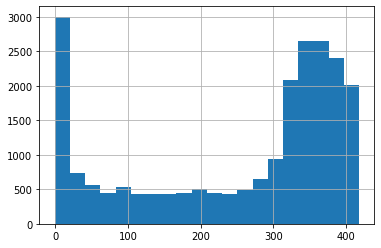

In [ ]:
# usage length distribution
df_members.USAGE_IN_DAYS.hist(bins=20)

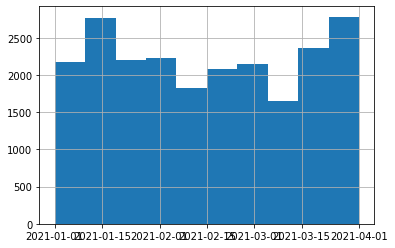

In [ ]:
# enrollment timing distribution
df_members.DATE_INITIAL_MEQ_SCORE.hist()

In [ ]:
# out of time(oot) test flag
df_members['OOT_FLAG'] = np.where(df_members['DATE_INITIAL_MEQ_SCORE']>'2021-02-28', 1, 0)

In [ ]:
df_members.OOT_FLAG.sum()

8072

## Factors table

In [ ]:
df_factors.head()

,USER_IDENTIFIER,FACTOR_EMPATHY,FACTOR_ENERGY,FACTOR_SUPPORT_SYSTEM,FACTOR_PROBLEM_SOLVING,FACTOR_MINDFULNESS,FACTOR_EATING_HABITS,FACTOR_PHYSICAL_ACTIVITY,FACTOR_ENGAGEMENT,FACTOR_EMOTIONAL_INTELLIGENCE,FACTOR_SELF_CONFIDENCE,FACTOR_PURPOSE,FACTOR_SLEEP,FACTOR_POSITIVITY,FACTOR_WORK_LIFE_BALANCE,FACTOR_EMOTION_CONTROL,FACTOR_STRESS_MANAGEMENT,FACTOR_FOCUS,FACTOR_PAIN_PROTECTION
0,3c1f93ec581c0f127902c229c87142a9ceb9b66bd20c2f...,35,45.8333,85,35,25,45,0.00,8.3333,40,50,80,37.5,45,45,33.3333,45.8333,25,50.00
1,c1a400561427c4737a52c1a8a9200d610e3183ba151df7...,45,33.3333,75,55,30,10,0.00,33.3333,35,60,60,12.5,45,25,22.2222,16.6667,20,18.75
2,eff0125b83107923bffe4e67005b1e4da69f82ea57b841...,75,50.0000,70,60,30,40,43.75,16.6667,60,45,20,25.0,45,55,25.0000,8.3333,40,31.25
3,d9708903cc6a494fe25374a8d7bc26c310b0ee3172b7fb...,85,79.1667,80,90,85,95,75.00,91.6667,95,75,85,100.0,95,50,75.0000,45.8333,85,100.00
4,584c47dd71a97d431106567d361b56fb10b9d41d3a18ce...,55,16.6667,45,35,25,35,6.25,16.6667,45,35,10,25.0,10,15,33.3333,0.0000,15,56.25


In [ ]:
df_factors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22266 entries, 0 to 22265
Data columns (total 19 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   USER_IDENTIFIER                22266 non-null  object 
 1   FACTOR_EMPATHY                 22266 non-null  int64  
 2   FACTOR_ENERGY                  22266 non-null  float64
 3   FACTOR_SUPPORT_SYSTEM          22266 non-null  int64  
 4   FACTOR_PROBLEM_SOLVING         22266 non-null  int64  
 5   FACTOR_MINDFULNESS             22266 non-null  int64  
 6   FACTOR_EATING_HABITS           22266 non-null  int64  
 7   FACTOR_PHYSICAL_ACTIVITY       22266 non-null  float64
 8   FACTOR_ENGAGEMENT              22266 non-null  float64
 9   FACTOR_EMOTIONAL_INTELLIGENCE  22266 non-null  int64  
 10  FACTOR_SELF_CONFIDENCE         22266 non-null  int64  
 11  FACTOR_PURPOSE                 22266 non-null  int64  
 12  FACTOR_SLEEP                   22266 non-null 

In [ ]:
df_factors.describe()

,FACTOR_EMPATHY,FACTOR_ENERGY,FACTOR_SUPPORT_SYSTEM,FACTOR_PROBLEM_SOLVING,FACTOR_MINDFULNESS,FACTOR_EATING_HABITS,FACTOR_PHYSICAL_ACTIVITY,FACTOR_ENGAGEMENT,FACTOR_EMOTIONAL_INTELLIGENCE,FACTOR_SELF_CONFIDENCE,FACTOR_PURPOSE,FACTOR_SLEEP,FACTOR_POSITIVITY,FACTOR_WORK_LIFE_BALANCE,FACTOR_EMOTION_CONTROL,FACTOR_STRESS_MANAGEMENT,FACTOR_FOCUS,FACTOR_PAIN_PROTECTION
count,22266.000000,22266.000000,22266.000000,22266.000000,22266.000000,22266.000000,22266.000000,22266.000000,22266.000000,22266.000000,22266.000000,22266.000000,22266.000000,22266.000000,22266.000000,22266.000000,22266.000000,22266.000000
mean,67.215485,64.907444,69.474984,68.666801,61.128627,53.219034,49.420080,62.400446,67.882646,72.142953,70.043789,58.865535,63.231384,56.072712,56.782513,50.201541,67.045046,64.826698
std,21.421848,20.730278,21.700980,18.450045,19.091642,21.596197,30.504851,22.921312,19.476592,17.591854,22.939333,28.475768,20.058249,25.017895,22.513058,24.127017,19.542492,25.715441
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,50.000000,55.000000,55.000000,50.000000,40.000000,25.000000,50.000000,55.000000,60.000000,55.000000,37.500000,50.000000,40.000000,38.888900,33.333300,55.000000,45.312500
50%,70.000000,66.666700,70.000000,70.000000,60.000000,55.000000,50.000000,66.666700,70.000000,75.000000,75.000000,62.500000,65.000000,55.000000,55.555600,50.000000,70.000000,68.750000
75%,85.000000,79.166700,85.000000,80.000000,75.000000,70.000000,75.000000,83.333300,80.000000,85.000000,90.000000,87.500000,80.000000,75.000000,75.000000,66.666700,80.000000,87.500000
max,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


## Session Table

In [ ]:
df_sessions.head()

,USER_IDENTIFIER,DATE_INITIAL_MEQ_SCORE,DATE_FIRST,DAYS_SINCE_ASSESSED,ELAPSED_SECONDS,EVENT_COUNT,IS_PURE_EMAIL,IS_MOBILE,ASSESS,EMAIL_OPEN,...,ACTIVITY,CALM_CAST,BREATHE,JOURNAL,REASSESS,COLLABORATE,USER_ACTION_WRITE,USER_ACTION_LISTEN,EMAIL_CLICK,PUSH_CLICK
2109,00016645b88d51f9c30ce4c1338178125aef1e37111667...,2021-01-14 20:04:40,2021-01-14 19:48:14,0,1103,37,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2110,00016645b88d51f9c30ce4c1338178125aef1e37111667...,2021-01-14 20:04:40,2021-01-15 04:28:20,1,0,1,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
36614,00016b96386f53adf2ea4beee032a8793e66e6ddd0ed28...,2021-01-31 18:14:27,2021-01-31 17:54:34,0,1326,34,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11468,00039767c3d802b128ce0c2c4b221bd4bc05ed226e0924...,2021-03-30 21:34:13,2021-03-30 15:32:43,0,291,12,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
11469,00039767c3d802b128ce0c2c4b221bd4bc05ed226e0924...,2021-03-30 21:34:13,2021-03-30 21:29:36,0,437,58,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0


In [ ]:
# login times
df_sessions.groupby('USER_IDENTIFIER').DATE_INITIAL_MEQ_SCORE.count().sort_values(ascending=False)

USER_IDENTIFIER
8760f8430566c9f4b5a2a5dd9004d13f0a92a2e2a2a4e081148d0017c1572f84    31
b0f5237b5e7f0855b2145f4f07406b664432ab70a74daf51e322be6c46b60a4e    31
cd389ce12ba902213ab00e567d0983d3788797ef023fbccd193b958894314f1d    30
c7bb78096db2a2aab6e446bd4a4ed2ebc81bc2ebfee2f7bc8eb12e68a4ddfb17    27
687a826e02ca27e3237fa3ed47f7b80c525af316f82baff0eb19323adc67b6f5    26
                                                                    ..
bc724293a4527087f1ae5f0f3ca285818b824902950422f081ca729a47e78ac6     1
bc6bd503b9a47c86b9fe4117da705ac3bdd45c00c4903fe1214e7339f8bad188     1
5a2664dfe1ca012ca8c14d405fa222eb3127a5c821f00859bd512a38f4584e6c     1
5a276451b6434446e4e91100ef9c7452bb419adf75bfb5d25c30f3302dc9da04     1
80436b945f654c3617ed73edc62dd8a2cfd53d17c0222e3e68b1cd350fcedfbd     1
Name: DATE_INITIAL_MEQ_SCORE, Length: 22266, dtype: int64

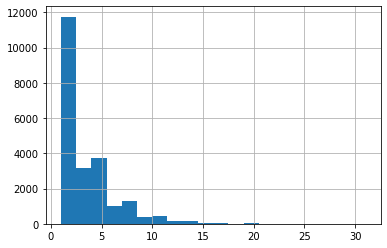

In [ ]:
df_sessions.groupby('USER_IDENTIFIER').DATE_INITIAL_MEQ_SCORE.count().hist(bins=20)

In [ ]:
df_sessions.shape

(73027, 27)

# Feature Engineering

In [ ]:
base_user_id = df_members[['USER_IDENTIFIER']]

In [ ]:
# num of users by client by the time a user enrolls
df_members['PLACEHOLDER']  = 1
df_members['NUM_of_USER_BY_CLIENT'] = df_members.sort_values('DATE_INITIAL_MEQ_SCORE', ascending=True).groupby('CLIENT_ID')['PLACEHOLDER'].cumsum()
df_members.drop(columns='PLACEHOLDER', inplace=True)

df_features_and_flags_from_members = df_members[['USER_IDENTIFIER', 'OOT_FLAG', 'CHURN_FLAG', 'CLIENT_ID', 'NUM_of_USER_BY_CLIENT', 'IS_OUS', 'IS_EMPLOYEE']]
# get dummies for CLIENT_ID
df_features_and_flags_from_members = pd.get_dummies(df_features_and_flags_from_members, columns=['CLIENT_ID'])


In [ ]:
# average of factors
df_factors['AVG_FACTOR'] = df_factors.iloc[:, 1:].mean(axis=1)
df_features_from_factors = df_factors

In [ ]:
# new features from session table
df_features_from_sessions = base_user_id.copy()

# total_session_cnt
df_temp = df_sessions.groupby('USER_IDENTIFIER')['USER_IDENTIFIER'].count().reset_index(name="total_session_cnt")
df_features_from_sessions = pd.merge(df_features_from_sessions, df_temp, on='USER_IDENTIFIER')

# total other actions
def get_total_actions(action, df_sessions, df_features_from_sessions):
  df_temp = df_sessions.groupby('USER_IDENTIFIER')[action].sum().reset_index(name=f"total_{action}")
  return pd.merge(df_features_from_sessions, df_temp, on='USER_IDENTIFIER')

actions = ['ELAPSED_SECONDS', 'EVENT_COUNT',
       'IS_PURE_EMAIL', 'IS_MOBILE', 'ASSESS', 'EMAIL_OPEN', 'BLOG', 'BROWSE',
       'SKILL', 'SEARCH', 'MOOD_TRACK', 'MOOD_TREND', 'MOOD_CHAT', 'ACTIVITY',
       'CALM_CAST', 'BREATHE', 'JOURNAL', 'REASSESS', 'COLLABORATE',
       'USER_ACTION_WRITE', 'USER_ACTION_LISTEN', 'EMAIL_CLICK', 'PUSH_CLICK']

for action in actions:
  df_features_from_sessions = get_total_actions(action, df_sessions, df_features_from_sessions)

In [ ]:
# merge for final df
df_temp = df_features_and_flags_from_members.merge(df_features_from_factors, on='USER_IDENTIFIER')
df_final = df_features_from_sessions.merge(df_temp, on='USER_IDENTIFIER')

In [ ]:
# creaet x, y for  train_validation and oot sets
df_tv = df_final.loc[df_final['OOT_FLAG'] == 0]
df_oot = df_final.loc[df_final['OOT_FLAG'] == 1]

df_y_tv = df_tv['CHURN_FLAG']
df_y_oot = df_oot['CHURN_FLAG']

df_x_tv = df_tv.loc[:, ~df_tv.columns.isin(['USER_IDENTIFIER', 'CHURN_FLAG', 'OOT_FLAG'])]
df_x_oot = df_oot.loc[:, ~df_oot.columns.isin(['USER_IDENTIFIER', 'CHURN_FLAG', 'OOT_FLAG'])]

# Modeling xgb

In [ ]:
#define dtrain
dtrain = xgb.DMatrix(data=df_x_tv, label=df_y_tv)

# define grid
df_grid1 = pd.DataFrame(columns=['max_depth', 'key'])
df_grid1['max_depth'] = [3, 6, 9]
df_grid1['key'] = 0

df_grid2 = pd.DataFrame(columns=['subsample', 'key'])
df_grid2['subsample'] = [0.3, 0.5, 0.7, 0.9]
df_grid2['key'] = 0

df_grid = df_grid1.merge(df_grid2, on='key', how='outer').drop(columns='key')


In [ ]:
df_grid

,max_depth,subsample
0,3,0.3
1,3,0.5
2,3,0.7
3,3,0.9
4,6,0.3
5,6,0.5
6,6,0.7
7,6,0.9
8,9,0.3
9,9,0.5


In [ ]:
def cv_fit(row_in_df_grid):
  dtrain = xgb.DMatrix(data=df_x_tv, label=df_y_tv)

  params = {'objective': 'binary:logistic'
            , 'eval_metric': 'logloss'
            , 'learning_rate': 0.1
            , 'scale_pos_weight': 6
            , 'max_depth': int(row_in_df_grid[0])
            , 'subsample': row_in_df_grid[1]
            }

  xgb_cv = xgb.cv(dtrain=dtrain
                , params=params
                , nfold=5
                , metrics='logloss'
                , num_boost_round=500
                , early_stopping_rounds=5
                , verbose_eval=True
                , seed=1234
                )

  # return num_boost with lowest test loss
  return np.insert(xgb_cv[-1:].values[0], 0, xgb_cv.shape[0])


df_grid[['num_boost', 'train_loss_mean', 'train_loss_std', 'test_loss_mean', 'test_loss_std']] = df_grid.apply(cv_fit, axis=1, result_type='expand')

df_grid.to_csv('/content/drive/My Drive/grid_search_result.csv', encoding='utf-8', index=False)


[0]	train-logloss:0.681797+0.000363293	test-logloss:0.681962+0.00142797
[1]	train-logloss:0.671414+0.00132377	test-logloss:0.67183+0.00310721
[2]	train-logloss:0.661966+0.00155355	test-logloss:0.662962+0.00312785
[3]	train-logloss:0.653696+0.00197149	test-logloss:0.65508+0.00458514
[4]	train-logloss:0.64718+0.00222739	test-logloss:0.648865+0.00471752
[5]	train-logloss:0.642051+0.00200094	test-logloss:0.643992+0.00475844
[6]	train-logloss:0.635981+0.00208465	test-logloss:0.638326+0.00507177
[7]	train-logloss:0.631429+0.00211533	test-logloss:0.634259+0.00555047
[8]	train-logloss:0.627665+0.00169911	test-logloss:0.630832+0.00495189
[9]	train-logloss:0.624185+0.00265374	test-logloss:0.627573+0.00459438
[10]	train-logloss:0.621112+0.00291012	test-logloss:0.624567+0.00521815
[11]	train-logloss:0.618295+0.00262296	test-logloss:0.621796+0.00662431
[12]	train-logloss:0.614713+0.00355879	test-logloss:0.618477+0.00796062
[13]	train-logloss:0.612734+0.00278165	test-logloss:0.616932+0.00722444
[14]

In [ ]:
df_grid.sort_values('test_loss_mean', ascending=True)


,max_depth,subsample,num_boost,train_loss_mean,train_loss_std,test_loss_mean,test_loss_std
2,3,0.7,230.0,0.335470,0.001298,0.364036,0.005029
3,3,0.9,218.0,0.338721,0.001063,0.364127,0.004431
0,3,0.3,160.0,0.345495,0.001176,0.365227,0.004967
1,3,0.5,156.0,0.345613,0.001421,0.365513,0.004160
6,6,0.7,118.0,0.292370,0.001196,0.365889,0.005008
7,6,0.9,126.0,0.287364,0.001054,0.366526,0.004643
5,6,0.5,89.0,0.311352,0.001084,0.367447,0.004588
4,6,0.3,92.0,0.316942,0.001191,0.368643,0.004793
10,9,0.7,84.0,0.243896,0.000689,0.368697,0.004071
9,9,0.5,80.0,0.261900,0.001284,0.368891,0.005002


In [ ]:
df_grid.to_csv('/content/drive/My Drive/df_grid.csv', encoding='utf-8', index=False)

In [ ]:
# fit best model from cv and get preds on oot_test set
xgb_classification = xgb.XGBClassifier(objetive='binary:logistic', subsample = 0.7, learning_rate=0.05, eval_metric='logloss', max_depth=3, alpha=0, n_estimators=230, verbosity=0, scale_pos_weight = 4, use_label_encoder=False)
xgb_classification.fit(df_x_tv, df_y_tv)
y_oot_pred = xgb_classification.predict(df_x_oot)
y_train_pred = xgb_classification.predict(df_x_tv)
y_oot_test = df_y_oot


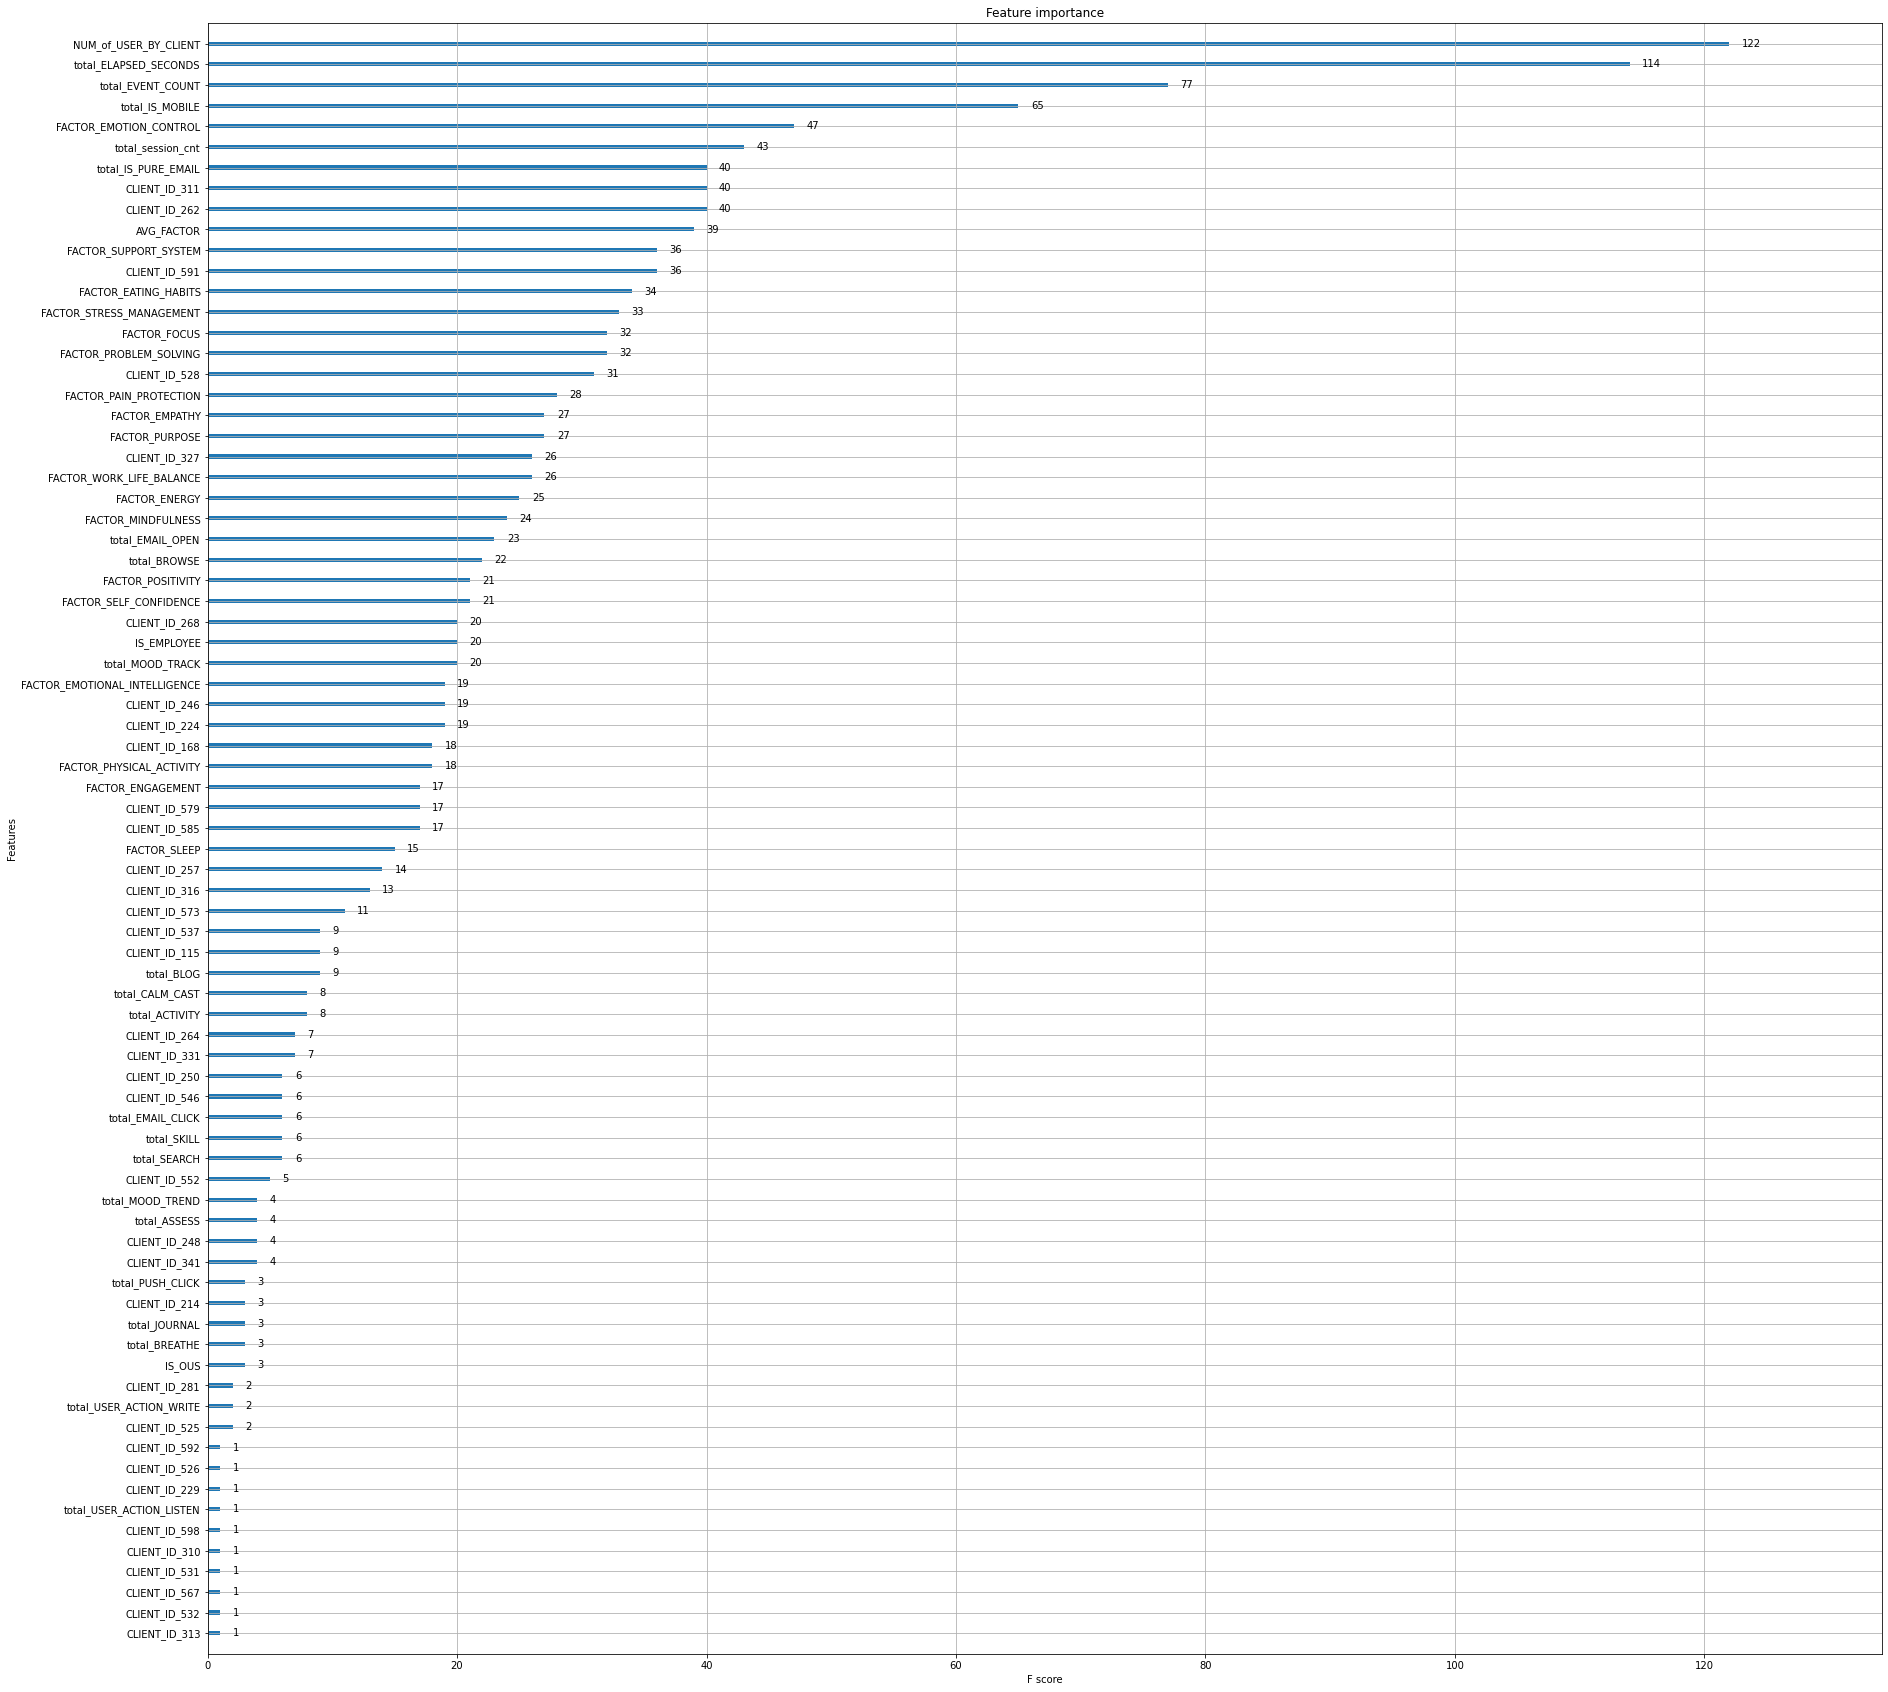

In [ ]:
xgb.plot_importance(xgb_classification)
plt.rcParams['figure.figsize'] = [30,30]
plt.show()

In [ ]:
# plot precision- recall curve

# y_oot_prob = xgb_classification.predict_proba(df_x_oot)[:, 1]
# precision, recall, thresholds = precision_recall_curve(y_oot_test, y_oot_prob)
# plt.plot(recall,precision, marker='.', label='xgb')
# plt.xlabel('Recall')
# plt.ylabel('Precision')
# # plt.rcParams['figure.figsize'] = [10, 10]
# plt.show()



# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(y_oot_test, y_oot_prob[:, 1])
roc_auc = auc(fpr, tpr)

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

IndexError: ignored

In [ ]:
f1_oot, auc_oot = f1_score(y_oot_test, y_oot_pred), roc_auc_score(y_oot_test, y_oot_pred)
print('f1_score-oot: ', f1_oot, 'auc-oot: ', auc_oot)
f1_train, auc_train = f1_score(df_y_tv, y_train_pred), roc_auc_score(df_y_tv, y_train_pred)
print('f1_score-train: ', f1_train, 'auc-train: ', auc_train)

f1_score-oot:  0.38446346280447663 auc-oot:  0.6314398589675206
f1_score-train:  0.45600722673893407 auc-train:  0.7140916524243496


In [ ]:
cm_oot = confusion_matrix(y_oot_test, y_oot_pred)
print('confusion_matrix_oot: ', cm_oot)

cm_train = confusion_matrix(df_y_tv, y_train_pred)
print('confusion_matrix_train: ', cm_train)

confusion_matrix_oot:  [[5618 1075]
 [ 795  584]]
confusion_matrix_train:  [[9921 2204]
 [ 807 1262]]


In [ ]:
acc_oot = accuracy_score(y_oot_test, y_oot_pred)
print('acc_oot: ', acc_oot)

acc_train = accuracy_score(df_y_tv, y_train_pred)
print('acc_train: ', acc_train)

acc_oot:  0.7683349851337958
acc_train:  0.7878681132873046


# Shap xgb

In [ ]:
explainer = shap.TreeExplainer(xgb_classification)
shap_values = explainer.shap_values(df_n))